In [1]:
# LaneNet Package Download
!git clone https://github.com/ms5898/LaneNet-PyTorch

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 163 (delta 41), reused 137 (delta 21), pack-reused 0
Receiving objects: 100% (163/163), 29.31 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
%cd LaneNet-PyTorch

/content/LaneNet-PyTorch


In [3]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
from PIL import Image
import imageio
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

original image


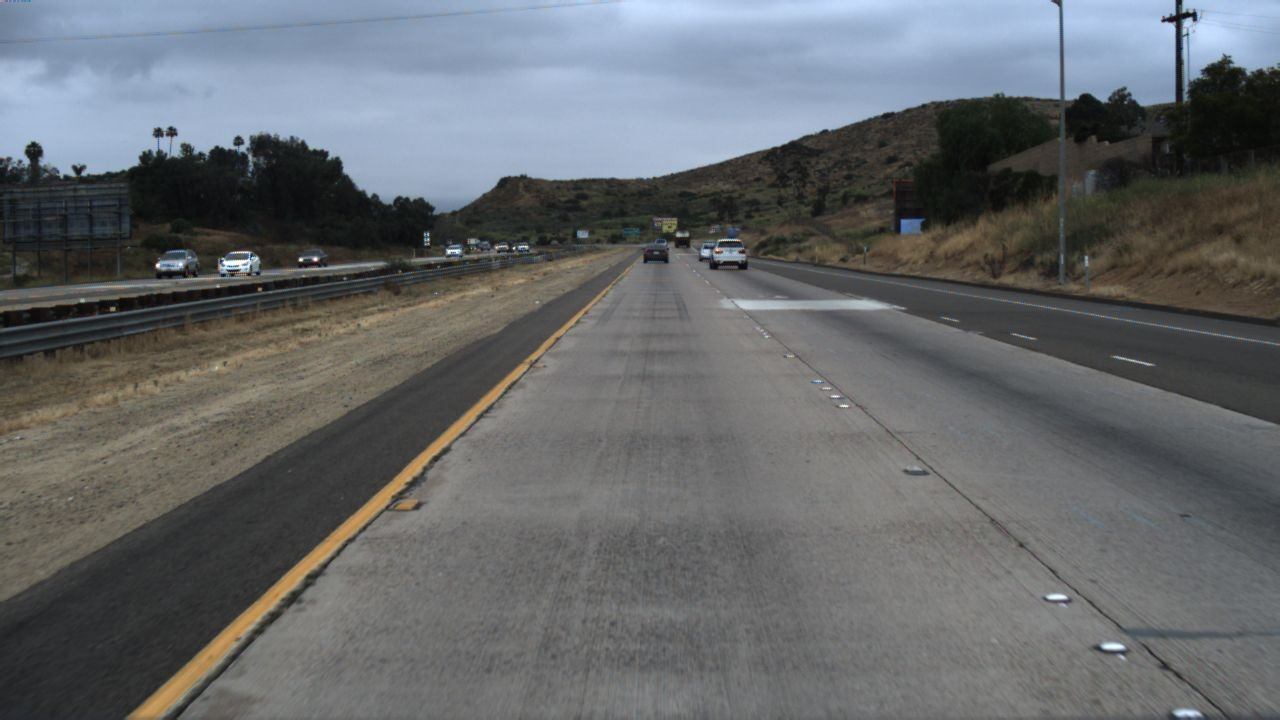

In [4]:
# image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
image = cv2.imread('TUSIMPLE/test_clips/1494453683523055480/1.jpg')

print("original image")
cv2_imshow(image)

lane segmentation


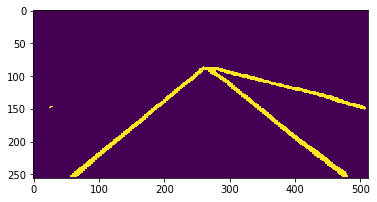

In [5]:
org_shape = image.shape
gt_image = cv2.resize(image, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
gt_image = gt_image / 127.5 - 1.0
gt_image = torch.tensor(gt_image, dtype=torch.float)
gt_image = np.transpose(gt_image, (2, 0, 1))
gt_image = gt_image.to('cpu')

# lane segmentation 
binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()

# removing sky area
binary_img[0:65,:] = 0

print("lane segmentation")
plt.imshow(binary_img, interpolation='nearest')
plt.show()

lane clustering


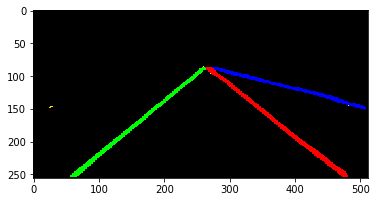

In [6]:
# lane clustering
rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img, distance=1.5, lane_num=4)

print("lane clustering")
plt.imshow(rbg_emb, interpolation='nearest')
plt.show()

result


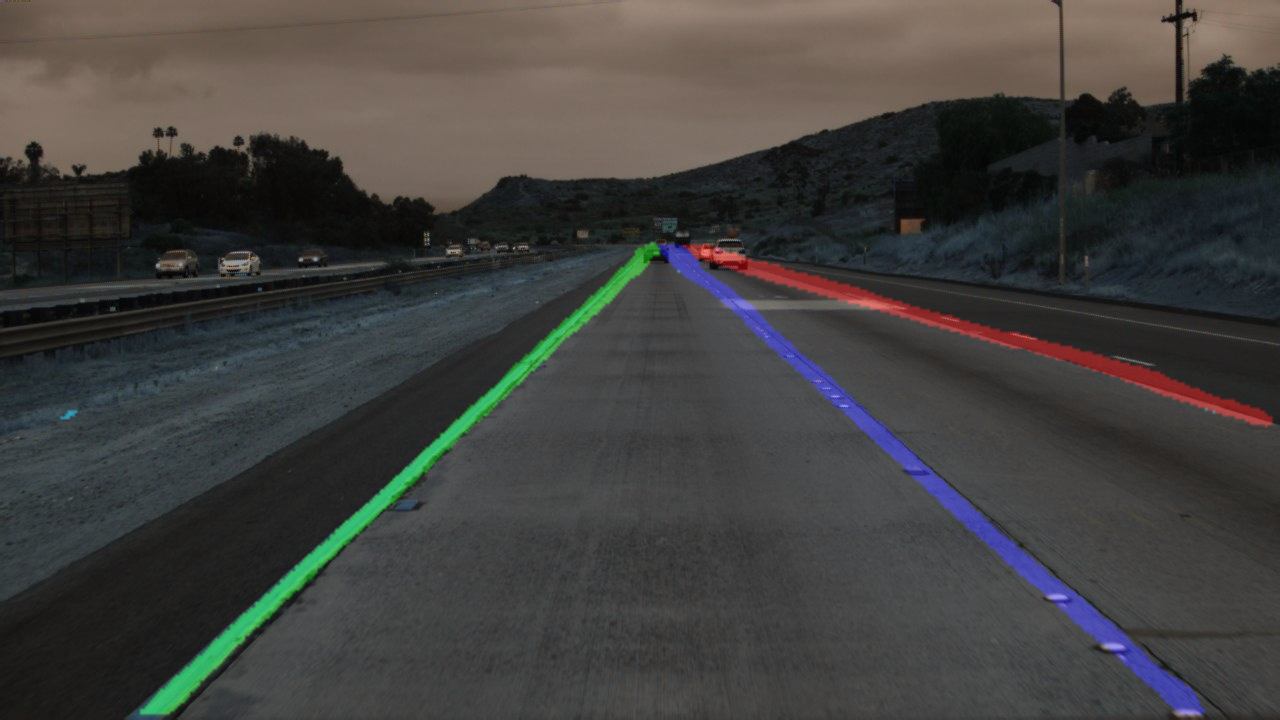

In [7]:
# segemented frame embedding
rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
a = 0.6
frame = a * image[..., ::-1] / 255 + rbg_emb * (1 - a)
frame = np.rint(frame * 255)
frame = frame.astype(np.uint8)

print("result")
cv2_imshow(frame)